# CLIP is all you need (c) [crumb](https://twitter.com/aicrumb)
Greatly inspired by [this tweet](https://twitter.com/aicrumb/status/1448351059957764096/photo/1) and all the CLIP guided approaches.

What if we directly optimize the raw image tesnor using CLIP instead of tuning a generator network or its inputs? 
Just like style transfer algos were doint 5 years ago :D

by [sxela](https://github.com/Sxela)

this notebook's repo: [github](https://github.com/Sxela/CLIPguidedRGB)

tip me: [paypal](http://paypal.me/sx3la)


In [1]:
!git clone https://github.com/openai/CLIP
!pip install -e ./CLIP -qq

Cloning into 'CLIP'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 164 (delta 31), reused 49 (delta 19), pack-reused 91
Receiving objects: 100% (164/164), 8.87 MiB | 22.64 MiB/s, done.
Resolving deltas: 100% (71/71), done.
     |████████████████████████████████| 64 kB 2.7 MB/s 


In [2]:
%cd CLIP
import torch
from torchvision.transforms import *
import clip
import PIL
import torch.nn.functional as F
from tqdm.notebook import trange
device='cuda'
model = clip.load('ViT-B/32',jit=False)[0].eval().requires_grad_(False).to(device)

/content/CLIP


100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 52.9MiB/s]


In [13]:
def get_sizes(sz, min_sz=32):
  szs = [sz]
  while True:
    if sz<=min_sz: return sorted(szs)
    if sz%2==0:
      sz = sz//2
      szs.append(sz)
    else: return sorted(szs)
  return sorted(szs)

def make_crop(img, ratio, max_cut=224, min_cut=0.2):
  w, h = img.shape[2:]
  min_sz = min(w,h)
  if min_cut<1: min_cut = int(min_sz*min_cut)
  crop_size = int(min(max(ratio*min_sz, min_cut), max_cut))

  w_offset = int(torch.rand(1)*(w-crop_size))
  h_offset = int(torch.rand(1)*(h-crop_size))

  cropped = img[:,:,w_offset:w_offset+crop_size,h_offset:h_offset+crop_size]
  return f(cropped)

def get_crops(img, ratios, max_cut, min_cut):
  return torch.cat([make_crop(img, ratio.item(), max_cut, min_cut) for ratio in ratios])

def show_img(t):
    img = PIL.Image.fromarray((t.permute(0,2,3,1)*127.5+128).clamp(0,255).to(torch.uint8)[0].cpu().numpy(),'RGB')
    display(img)

def fit(t, size, steps=1000, ncut=8, max_sz=224, min_sz=32, use_weighted_ratios=True):
  z2 = F.interpolate(t, (size,size), mode='bicubic')
  t = z2.detach().clone().requires_grad_(True)
  show_img(t)
  opt=torch.optim.Adam([t],lr=lr)
  for i in trange(steps):
    opt.zero_grad()

    ratios = [torch.ones(1).cuda()]
    for j in range(ncut):
      ratios.append(torch.rand(1).cuda())
    ratios = torch.cat(ratios)
    crops = get_crops(t, ratios, max_sz, min_sz)
    loss_avg = 0.
    loss = 0.
    weighted_ratios = ratios/ratios.sum() if use_weighted_ratios else torch.ones_like(ratios).to(device)

    for crop, ratio in zip(crops, weighted_ratios):
      x = F.normalize(model.encode_image(crop[None,...]), dim=-1)
      loss+=torch.sqrt(criterion(x, y))*ratio

    loss.backward()
    opt.step()
    loss_avg = loss if loss_avg==0. else (loss_avg*loss_lerp+loss*(1-loss_lerp))
    if i % 100 == 0: 
      print(loss_avg.item())
    if i % 500 == 0: 
      show_img(t)
  show_img(t)
  return t

criterion = torch.nn.MSELoss()
f=Compose([Resize(224),
          Lambda(lambda x:torch.clamp((x+1)/2,0,1)),
          RandomGrayscale(p=.2),
          Lambda(lambda x: x+torch.randn_like(x)*0.01)])


[64, 128, 256, 512, 1024]
64 2000 8


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


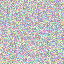

  0%|          | 0/2000 [00:00<?, ?it/s]

0.05528617650270462


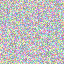

0.05292897671461105
0.050200678408145905
0.04974507912993431
0.048125483095645905
0.0477585606276989


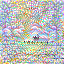

0.04841241240501404
0.05038461089134216
0.04573971778154373
0.049262307584285736
0.047566235065460205


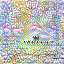

0.0484590083360672
0.04719291627407074
0.04773516580462456
0.050716251134872437
0.044734660536050797


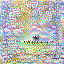

0.04782674461603165
0.04672302305698395
0.04669300094246864
0.045400869101285934


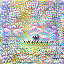

128 2000 8


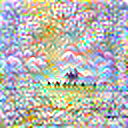

  0%|          | 0/2000 [00:00<?, ?it/s]

0.05306177958846092


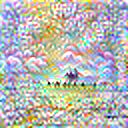

0.05045834928750992
0.0499158538877964
0.050246257334947586
0.0487675815820694
0.04924526810646057


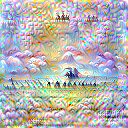

0.04844491556286812
0.04908943548798561
0.049056511372327805
0.048940278589725494
0.04701480269432068


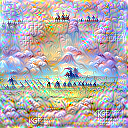

0.048241108655929565
0.04779653996229172
0.04855024814605713
0.04690426215529442
0.04689449816942215


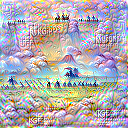

0.047912634909152985
0.04678914695978165
0.047603704035282135
0.046983566135168076


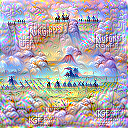

256 2000 8


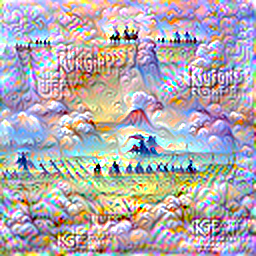

  0%|          | 0/2000 [00:00<?, ?it/s]

0.05311102420091629


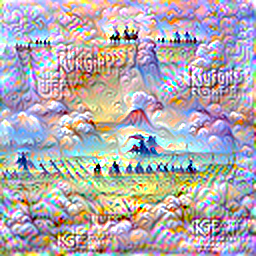

0.05119043216109276
0.050062622874975204
0.049246370792388916
0.04922741651535034
0.04947686940431595


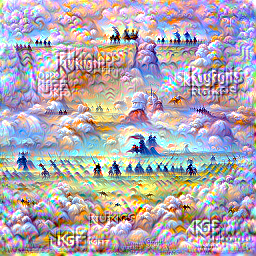

0.04986472427845001
0.04853260517120361
0.04794784262776375
0.04771031439304352
0.04786446690559387


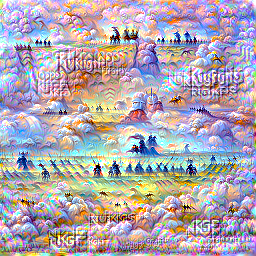

0.04815664142370224
0.048104722052812576
0.04749041050672531
0.04763566702604294
0.04659610241651535


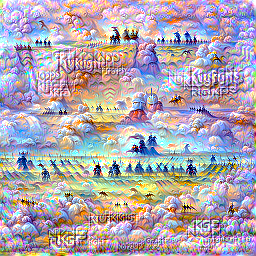

0.04745432361960411
0.048045992851257324
0.04671546444296837
0.0467461459338665


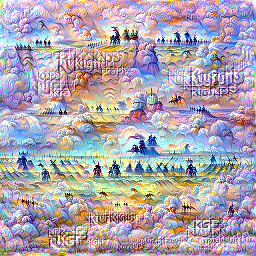

512 2000 16


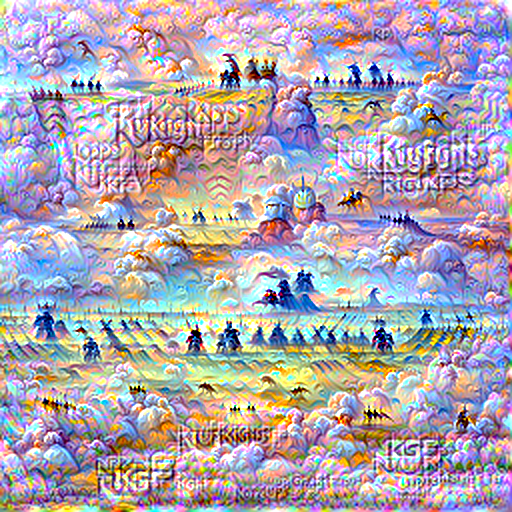

  0%|          | 0/2000 [00:00<?, ?it/s]

0.054211802780628204


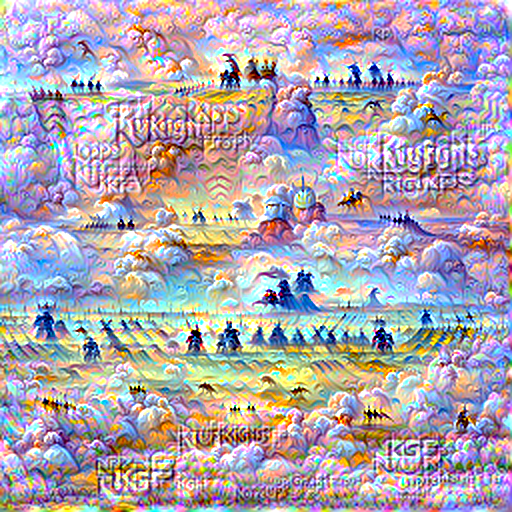

0.05180957540869713
0.05152922496199608
0.05075832083821297
0.05044889822602272
0.050138745456933975


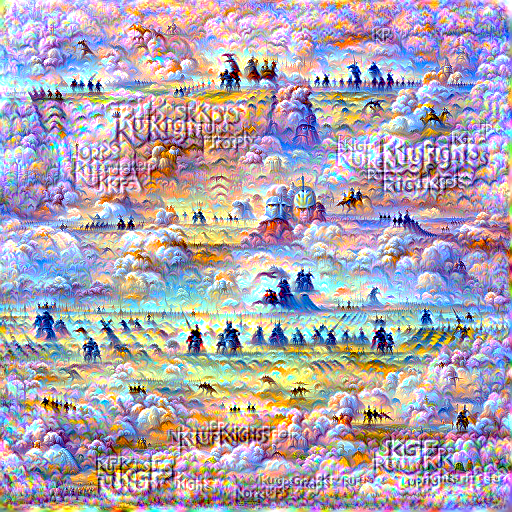

0.05028891563415527
0.04997846111655235
0.049426622688770294
0.04967435076832771
0.04975229129195213


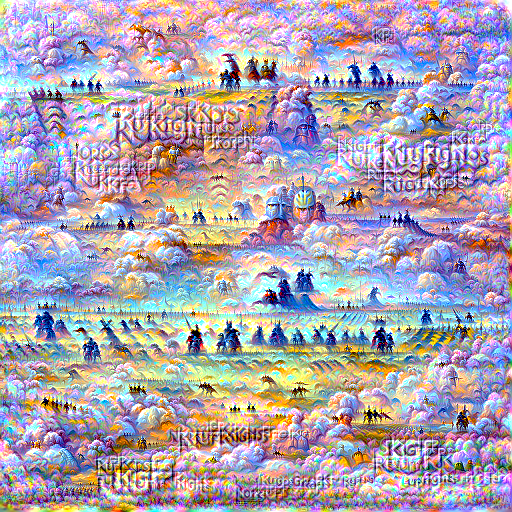

0.04925428330898285
0.049116723239421844
0.04999155551195145
0.049519263207912445
0.04904516786336899


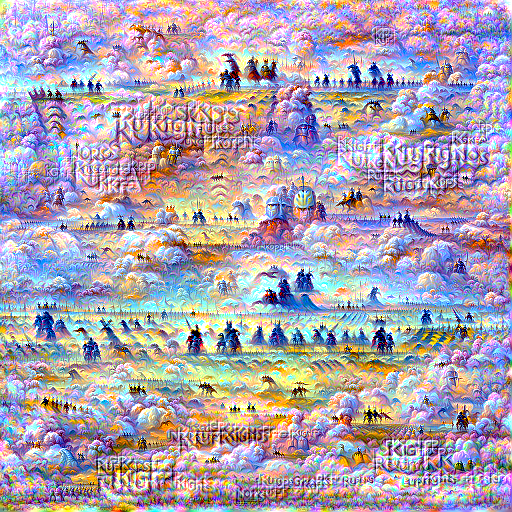

0.04940555617213249
0.04904976487159729
0.04978266358375549
0.04888489097356796


In [ ]:
prompt = 'a landscape containing knights riding on the horizon by Greg Rutkowski' #text prompt
seed = 0 
torch.manual_seed(seed)

szs = get_sizes(1024, 64); print(szs) #getting sizes
steps = [2000]*len(szs) #getting number of steps per size
cuts = [8,8,8,16,24] #number of image cuts for CLIP loss per iteration
max_szs=[64]*len(szs) #max cut size (pixels)
min_szs=[0.2]*len(szs) #min cut size (pixel or image size ratio)

lr=1e-2
loss_lerp = 0.6 #used for display only

encoded_prompt = model.encode_text(clip.tokenize(prompt).to(device))
y = F.normalize(encoded_prompt, dim=-1)

#init image, can be replaced with a photo
z=torch.rand((1,3,szs[0],szs[0]),device=device,requires_grad=True)

for size, step, cut, max_sz, min_sz in zip(szs, steps, cuts, max_szs, min_szs):
  print(size, step, cut)
  z = fit(z, size, steps=step, ncut=cut, max_sz=max_sz, min_sz=min_sz)